# Levi Pandas Accessor
## Transform between and among different graph data representations via a Levi graph

Helpful links:  
https://jendobson.com/2020/06/12/writing-custom-accessors-to-avoid-subclassing-pandas-dataframes/  
https://en.wikipedia.org/wiki/Levi_graph

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import networkx as nx
import matplotlib.pyplot as plt
import beartype as bt

plt.rcParams['figure.dpi'] = 60

### Create data to use in development:
- Token Co-occurrence matrix
- Document-term matrix (this is an example of a bipartite structure/incidence matrix)
- COO (format: multi-index pandas Series)


In [2]:
# Create sample dataset

doc_ids = [str(x) for x in range(5)]
texts = [
    "the quick brown fox jumped",
    "the fox jumped",
    "the dog jumped",
    "one brown fox",
    "ten brown dogs",
   ]

df = pd.DataFrame({'doc_id': doc_ids,
                    'text':texts,
                    })

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words=['the'])
cv.fit(df['text'])
tokens = cv.get_feature_names_out()  #alphabetical

In [4]:
tokens

array(['brown', 'dog', 'dogs', 'fox', 'jumped', 'one', 'quick', 'ten'],
      dtype=object)

In [5]:
# Create cooccurence matrix

results = cv.transform(df['text'])
coocc = results.T.dot(results)
# np.fill_diagonal(coocc.values, 0)
coocc = pd.DataFrame(results.T.dot(results).toarray(), index=pd.CategoricalIndex(tokens), columns=pd.CategoricalIndex(tokens))
np.fill_diagonal(coocc.values, 0)
coocc

,brown,dog,dogs,fox,jumped,one,quick,ten
brown,0,0,1,2,1,1,1,1
dog,0,0,0,0,1,0,0,0
dogs,1,0,0,0,0,0,0,1
fox,2,0,0,0,2,1,1,0
jumped,1,1,0,2,0,0,1,0
one,1,0,0,1,0,0,0,0
quick,1,0,0,1,1,0,0,0
ten,1,0,1,0,0,0,0,0


In [6]:
# Create document term matrix (BIPARTITE STRUCTURE)

results = cv.transform(df['text'])
features = cv.get_feature_names_out()
doc_term = pd.DataFrame(results.toarray(), columns=features)
doc_term = doc_term.reindex(columns=doc_term.columns.tolist()+['cat', 'bear', 'tree'], fill_value=0)
doc_term

,brown,dog,dogs,fox,jumped,one,quick,ten,cat,bear,tree
0,1,0,0,1,1,0,1,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0
3,1,0,0,1,0,1,0,0,0,0,0
4,1,0,1,0,0,0,0,1,0,0,0


In [7]:
# Create COO Dataframe
# using scipy sparse module here, but we want to avoid it in production
coo_matrix = sparse.coo_matrix(doc_term.values)
coo_rows = coo_matrix.row
coo_cols = coo_matrix.col
coo_vals = coo_matrix.data

term_dict = dict(zip(range(0,11), doc_term.columns))
term_dict

{0: 'brown',
 1: 'dog',
 2: 'dogs',
 3: 'fox',
 4: 'jumped',
 5: 'one',
 6: 'quick',
 7: 'ten',
 8: 'cat',
 9: 'bear',
 10: 'tree'}

In [8]:
print(coo_matrix)  #scipy sparse format

  (0, 0)	1
  (0, 3)	1
  (0, 4)	1
  (0, 6)	1
  (1, 3)	1
  (1, 4)	1
  (2, 1)	1
  (2, 4)	1
  (3, 0)	1
  (3, 3)	1
  (3, 5)	1
  (4, 0)	1
  (4, 2)	1
  (4, 7)	1


In [9]:
coo_cols = coo_cols.tolist()
coo_col_names = [term_dict[key] for key in coo_cols]

In [10]:
idx=pd.MultiIndex.from_arrays([coo_matrix.row, coo_col_names])
coo = pd.DataFrame(coo_matrix.data, index=idx, columns=["flag"])
coo

flag
0 brown      1
  fox        1
  jumped     1
  quick      1
1 fox        1
  jumped     1
2 dog        1
  jumped     1
3 brown      1
  fox        1
  one        1
4 brown      1
  dogs       1
  ten        1

In [11]:
coo.index

MultiIndex([(0,  'brown'),
            (0,    'fox'),
            (0, 'jumped'),
            (0,  'quick'),
            (1,    'fox'),
            (1, 'jumped'),
            (2,    'dog'),
            (2, 'jumped'),
            (3,  'brown'),
            (3,    'fox'),
            (3,    'one'),
            (4,  'brown'),
            (4,   'dogs'),
            (4,    'ten')],
           )

In [12]:
# new = pd.CategoricalDtype(coo.index)
# new

In [13]:
levi_series = coo.squeeze()
levi_series.index

MultiIndex([(0,  'brown'),
            (0,    'fox'),
            (0, 'jumped'),
            (0,  'quick'),
            (1,    'fox'),
            (1, 'jumped'),
            (2,    'dog'),
            (2, 'jumped'),
            (3,  'brown'),
            (3,    'fox'),
            (3,    'one'),
            (4,  'brown'),
            (4,   'dogs'),
            (4,    'ten')],
           )

### Converting Levi series to other graph formats

In [14]:
from levi import dataframe, series

levi_series.levi.to_edgelist(level_0="doc", level_1="term")

*** test validator***


/Users/amc8/grabble/notebooks/levi/__init__.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


,doc,term,flag
0,0,brown,1
1,0,fox,1
2,0,jumped,1
3,0,quick,1
4,1,fox,1
5,1,jumped,1
6,2,dog,1
7,2,jumped,1
8,3,brown,1
9,3,fox,1


In [15]:
# test failed validation function

# not_levi_series = pd.Series([0,7,8])
# series_empty.levi.to_incidence

In [16]:
from levi import series

levi_series.levi.to_adjacency

,brown,dog,dogs,fox,jumped,one,quick,ten
brown,0,0,1,2,1,1,1,1
dog,0,0,0,0,1,0,0,0
dogs,1,0,0,0,0,0,0,1
fox,2,0,0,0,2,1,1,0
jumped,1,1,0,2,0,0,1,0
one,1,0,0,1,0,0,0,0
quick,1,0,0,1,1,0,0,0
ten,1,0,1,0,0,0,0,0


In [17]:
edgelist = levi_series.levi.to_edgelist(level_0="doc", level_1="term")
edgelist['doc'] = pd.Categorical(edgelist.doc)
edgelist['term'] = pd.Categorical(edgelist.term)

In [18]:
edgelist

,doc,term,flag
0,0,brown,1
1,0,fox,1
2,0,jumped,1
3,0,quick,1
4,1,fox,1
5,1,jumped,1
6,2,dog,1
7,2,jumped,1
8,3,brown,1
9,3,fox,1


### Converting between different formats, using Levi as common intermediate format

In [19]:
def edgelist_to_incidence(edgelist, node_colname, value_colname=None):
    """assume edgelist is indexed by edge number, not some edge set of names (for now)"""
    data = np.ones_like(edgelist.index.values) if value_colname == None else edgelist[value_colname].values
    return sparse.coo_array((data, (edgelist.index, edgelist[node_colname].cat.codes)), shape=(edgelist.shape[0], len(edgelist[node_colname].cat.categories)))  # coo_array((data, (row_idx, col_idx)))

In [20]:
inc = edgelist_to_incidence(edgelist, node_colname='term')
print(inc)

  (0, 0)	1
  (1, 3)	1
  (2, 4)	1
  (3, 6)	1
  (4, 3)	1
  (5, 4)	1
  (6, 1)	1
  (7, 4)	1
  (8, 0)	1
  (9, 3)	1
  (10, 5)	1
  (11, 0)	1
  (12, 2)	1
  (13, 7)	1


In [ ]:
# tuple_list = list(zip(coo_rows, coo_col_names, coo_matrix.data))
tuple_list = list(zip(coo_rows, coo_col_names, ))
tuple_list_w_data = [(*t, 1) for t in tuple_list]

In [ ]:
import itertools
row_index = dict(zip(tuple_list_w_data, itertools.count()))
row_index

In [ ]:
# array_x = nx.algorithms.bipartite.biadjacency_matrix(graph, row_order=tuple_list_w_data)
# array_x

In [ ]:
# Make sure pandas categorical works with ints
#   - in nb, ss example has index as ints, not categoricals
#   - pandas_categoricals

In [ ]:
coo.unstack(level=1, )

In [ ]:
type(coocc)

In [ ]:
import levi

coo.levi

For now, assume "input" is a doc-term matrix

In [ ]:
# from affinity-to-edge

def affinity_to_edge(source_name,  # type: str
    target_name,  # type: str
    affinity,  # type: DF
    value_name=None  # type: Optional[str]
    ):
# type: (...) -> DF
    """DEPRECATED"""
    return (affinity.reset_index().melt(source_name, value_name=value_name, var_name=target_name).query('weight>0'))


In [ ]:
doc_term.columns.dtype

## Testing dataframe accessor

In [ ]:
# ba = edgelist.levi.edgelist_to_biadjacency()
# ba

### Creating a new Levi graph: Key feature of Grabble
#### Example: combining "students" and "reviewers" into new "people" category

what to call this??

In [ ]:
# edgelist.set_index([edgelist.index, 'doc'])['flag'], #.notna(#.sum(axis=1))

In [ ]:
levi_series.index.dtypes

In [ ]:
def new_levi(og_levi, ):
    el = og_levi.levi.to_edgelist()
    new_index = pd.MultiIndex.from_arrays([el.index, list(zip(el.level_0, el.level_1))])
    new_levi = pd.Series(data=el.flag.values, index=new_index)
    # new_levi = el.set_index([el.index, list(zip(el.level_0, el.level_1))])
    return new_levi

test_new_levi = new_levi(levi_series)
test_new_levi

In [ ]:
type(test_new_levi)

In [ ]:
import levi

test_adj = test_new_levi
test_adj

In [ ]:
# Notes/code scratchwork from meeting on 3/16

edgelist
pd.concat([
    edgelist.set_index([edgelist.index, 'doc'])['flag'], #.notna(#.sum(axis=1))
    edgelist.set_index([edgelist.index, 'term'])['flag']
]) #.index

# pd.CategoricalDtype

In [ ]:
# more notes
from scipy.sparse import coo_array

# A = coo_array(students@stuents.T)
A = coo_array(coocc@coocc.T)
# pd.Series.sparse.from_coo(A).unstack()
# pd.Series(index= pd.MultiIndex.from_arrays([A.row, A.col]))

In [ ]:
levi_series

In [ ]:
new_levi = edgelist.set_index(edgelist.index, edgelist.columns[0]) #.unstack()
new_levi

In [ ]:
levi_series

## pandas-flavor

another approach to extending pandas for levi?

In [ ]:
# example code using pandas-flavor

def add_method(key, val, fn_name=None):  
    def fn(df):
        return df.loc[df[key] == val]

    if fn_name is None:
        fn_name = f'{key}_{val}'

    fn.__name__ = fn_name
    fn = pf.register_dataframe_method(fn)
    return fn

for name1 in ['john', 'lisa']:
    add_method('name1', name1)

for name2 in ['fay', 'meg', 'wil']:
    add_method('name2', name2)


# OR, another approach:

@pf.register_dataframe_method
def name1(df, val):
    return df.loc[df['name1'] == val]

@pf.register_dataframe_method
def name2(df, val):
    return df.loc[df['name2'] == val]

test.name1('lisa')
#   name1 name2  scoreA  scoreB
# 1  lisa   wil    9.67    8.87
# 2  lisa   fay    3.41    5.04
# 3  lisa   wil    0.58    6.12

test.name1('lisa').name2('wil')
#   name1 name2  scoreA  scoreB
# 1  lisa   wil    9.67    8.87
# 3  lisa   wil    0.58    6.12

### Type validation, `beartype` stuff (mostly scratchwork)

In [ ]:
from beartype import beartype
from beartype import typing as bt
from beartype.door import TypeHint as th

from typing_extensions import NamedTuple
import static_frame as sf

from dataclasses import dataclass, InitVar
import networkx as nx
# from typing import NamedTuple
from IPython.display import display
import numpy as np
from numpy.typing import DTypeLike

In [ ]:
from beartype import beartype
from beartype.vale import IsAttr, IsEqual, IsSubclass, IsInstance
from typing import Annotated  

In [ ]:
# Type hint matching only two-dimensional NumPy arrays of floats of
# arbitrary precision. This time, do it faster than anyone has ever
# type-checked NumPy arrays before. (Cue sonic boom, Chuck Yeager.)
import numpy as np
Numpy2DFloatArray = Annotated[np.ndarray,
    IsAttr['ndim', IsEqual[2]] &
    IsAttr['dtype', IsAttr['type', IsSubclass[np.floating]]]
]

In [ ]:
levi_series.index

In [ ]:
series_2Dindex = Annotated[pd.Series, # need this Series?
    IsInstance[pd.Series] &
    IsAttr['index', IsInstance[pd.MultiIndex]]
]

In [ ]:
@beartype
def test_series_stuff(levi: series_2Dindex):
    print("*** TEST ***")

test_series_stuff(levi_series)

In [ ]:
test_series_stuff(edgelist)

In [34]:
test_series_stuff(levi)

NameError: name 'test_series_stuff' is not defined

In [ ]:
from phantom import Phantom
from phantom.predicates import Predicate
import beartype.typing as bt
from beartype.door import is_bearable


In [ ]:
def of_beartype(t: bt.Union[type, bt.Tuple[type, ...]]) -> Predicate[object]:
    """ From `phantom.predicates.generic.of_type`

    Create a new predicate that succeeds when its argument is bearable on ``t``.
    """

    def check(a: object) -> bool:
        return is_bearable(a, t)

    return check

In [ ]:
# chck = of_beartype(coo)
# chck(coo)

In [33]:
# beartype sample code

# Annotate @beartype-decorated callables with beartype validators.
@beartype
def polygon_area(polygon: Numpy2DFloatArray) -> float:
    '''
    Area of a two-dimensional polygon of floats defined as a set of
    counter-clockwise points, calculated via Green's theorem.

    *Don't ask.*
    '''

    # Calculate and return the desired area. Pretend we understand this.
    polygon_rolled = np.roll(polygon, -1, axis=0)
    return np.abs(0.5*np.sum(
        polygon[:,0]*polygon_rolled[:,1] -
        polygon_rolled[:,0]*polygon[:,1]))


NameError: name 'beartype' is not defined

In [ ]:
from beartype.vale import IsInstance
class Token(str):
    ...

@beartype
class Tester(bt.Annotated[str, IsInstance[Token]]):
    ...

isinstance(Tester('abc'), Token)

In [ ]:
# # Import the requisite machinery.
# from beartype.vale import Is
# from typing import Annotated   # <--------------- if Python ≥ 3.9.0

# # Type hint matching only strings with lengths ranging [4, 40].
# LengthyString = Annotated[str, Is[lambda text: 4 <= len(text) <= 40]]

# test_typing = Annotated[pd.Series, Is[pd.Series]]
# test_typing


In [ ]:
# ids = ('id-student', 'id-project')

# testing = doc_term.reset_index().melt(0, value_name="brown", ).query('weight>0')   #var_name=target_name
# testing

In [25]:
# pd.DataFrame.melt

# testing = doc_term.reset_index().melt(source_name, value_name=value_name, var_name=target_name).query('weight>0')
# testing

### Plotting Graphs
Plan to eventually add functionality in Grabble to easily plug into packages for easy plotting, compatable with the Levi-format workflow. Notworkx and Hypernetx are two options.

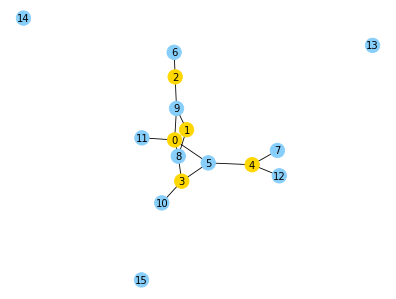

In [26]:
graph = nx.algorithms.bipartite.from_biadjacency_matrix(coo_matrix)
sets = nx.get_node_attributes(graph, name="bipartite")
colors = {0: 'gold', 1: 'lightskyblue'}

nx.draw(graph, with_labels=True, node_color=[colors[node[1]['bipartite']] 
                    for node in graph.nodes(data=True)])


In [28]:
graph.edges()

EdgeView([(0, 5), (0, 8), (0, 9), (0, 11), (1, 8), (1, 9), (2, 6), (2, 9), (3, 5), (3, 8), (3, 10), (4, 5), (4, 7), (4, 12)])

In [29]:
# Plotting with HyperNetx
import hypernetx as hnx

In [30]:
term_doc = doc_term.T

In [31]:
# *HNX* hypergraphs can be built from networkx bipartite graph objects using `from_bipartite`
H = hnx.Hypergraph.from_dataframe(term_doc)

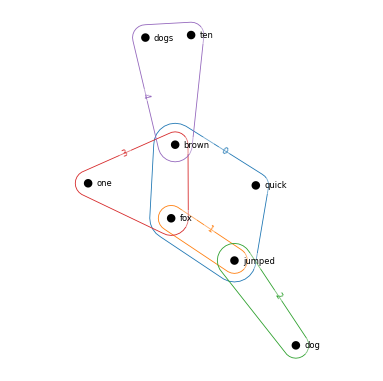

In [32]:
hnx.drawing.draw(H)